### 0. Imports and setup

In [1]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import rgb2hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [3]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 4 or i > 12:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [4]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


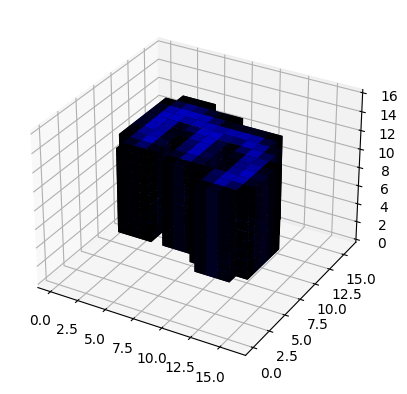

In [5]:
plot_img(next(iter(mnist_train_a))[0])

### 3. Preparation for the training

In [6]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [7]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [8]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [9]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [10]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

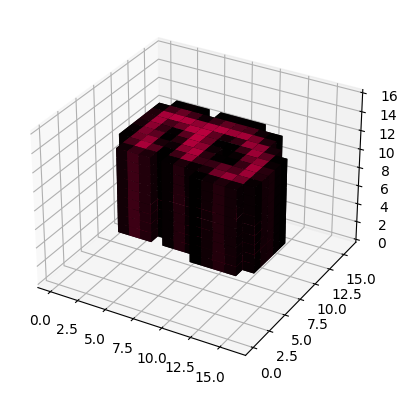

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: 0.1637217104434967;  f_loss: 0.00840312335640192


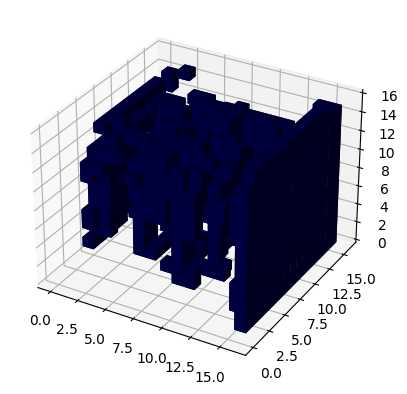

  2%|▏         | 100/5001 [01:09<56:11,  1.45it/s]

T_loss: -0.014681694097816944;  f_loss: -0.007786847651004791


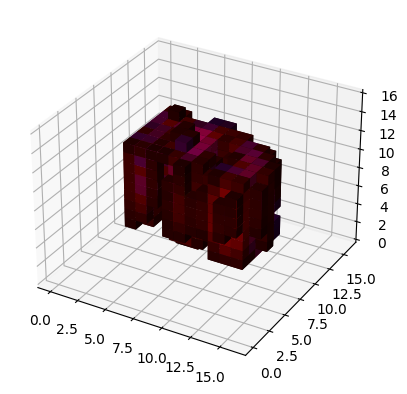

  4%|▍         | 200/5001 [02:18<55:26,  1.44it/s]  

T_loss: -0.010944325476884842;  f_loss: -0.0023407787084579468


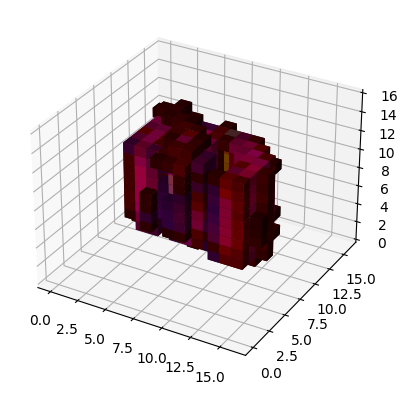

  6%|▌         | 300/5001 [03:28<54:13,  1.44it/s]  

T_loss: 0.09736912697553635;  f_loss: -0.014136575162410736


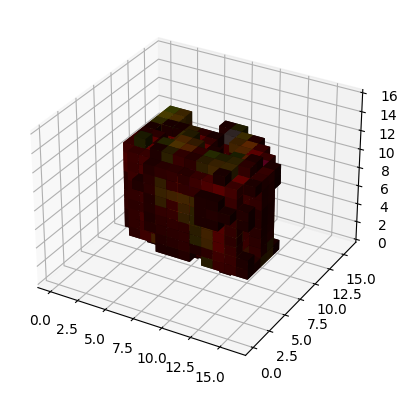

  8%|▊         | 400/5001 [04:38<53:12,  1.44it/s]  

T_loss: -0.18356768786907196;  f_loss: -0.00639769434928894


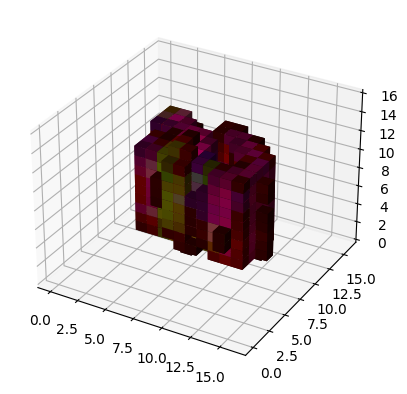

 10%|▉         | 500/5001 [05:47<51:58,  1.44it/s]  

T_loss: -0.28101038932800293;  f_loss: -0.009391635656356812


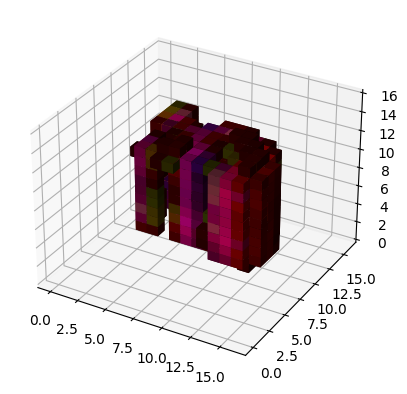

 12%|█▏        | 600/5001 [06:57<50:47,  1.44it/s]  

T_loss: -16.63043975830078;  f_loss: -0.6943588256835938


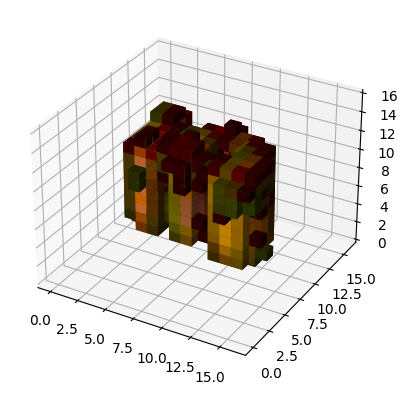

 14%|█▍        | 700/5001 [08:07<49:22,  1.45it/s]  

T_loss: -0.650573194026947;  f_loss: -0.07328164577484131


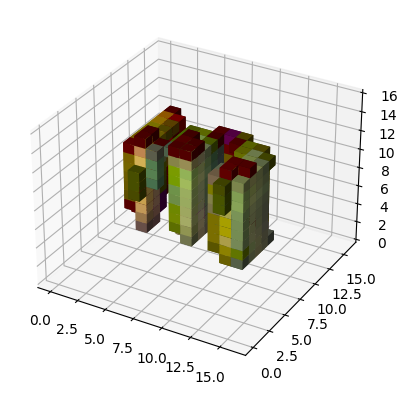

 16%|█▌        | 800/5001 [09:16<48:27,  1.44it/s]

T_loss: -4.152136325836182;  f_loss: -0.2950906753540039


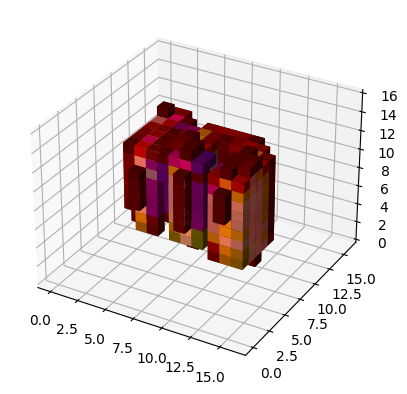

 18%|█▊        | 900/5001 [10:26<47:19,  1.44it/s]

T_loss: 7.867313385009766;  f_loss: -0.8956012725830078


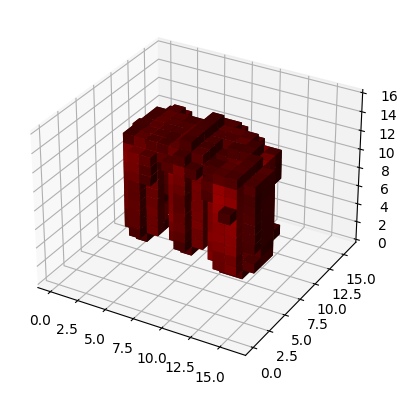

 20%|█▉        | 1000/5001 [11:35<46:05,  1.45it/s]

T_loss: -36.074825286865234;  f_loss: 27.894128799438477


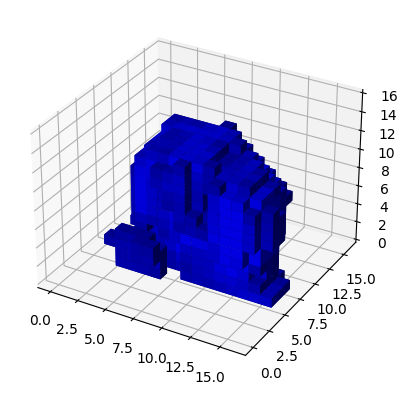

 22%|██▏       | 1100/5001 [12:45<44:40,  1.46it/s]

T_loss: -3.3690526485443115;  f_loss: -8.467432022094727


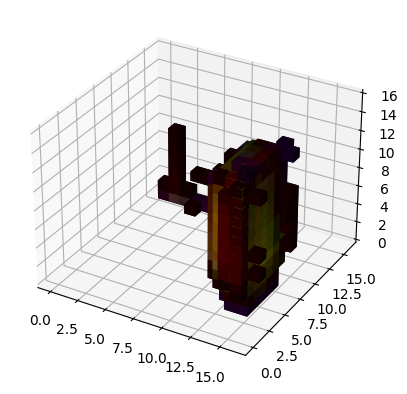

 24%|██▍       | 1200/5001 [13:55<43:49,  1.45it/s]

T_loss: -2.755467653274536;  f_loss: 0.08432626724243164


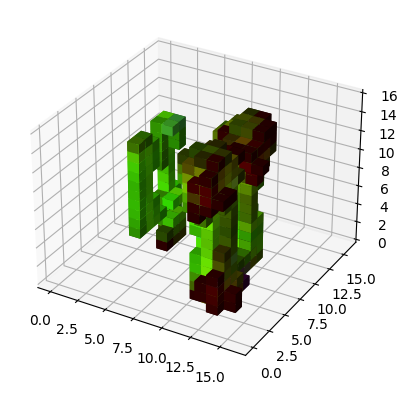

 26%|██▌       | 1300/5001 [15:04<42:42,  1.44it/s]

T_loss: -1.2065067291259766;  f_loss: -0.2506296634674072


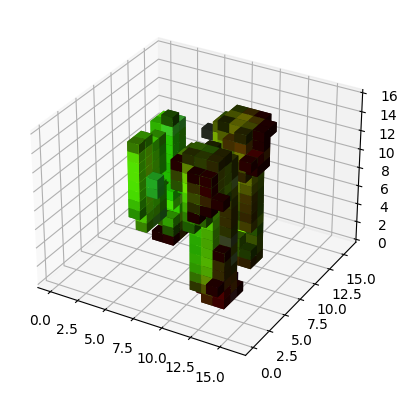

 28%|██▊       | 1400/5001 [16:14<41:28,  1.45it/s]

T_loss: -2.2670376300811768;  f_loss: -0.20017647743225098


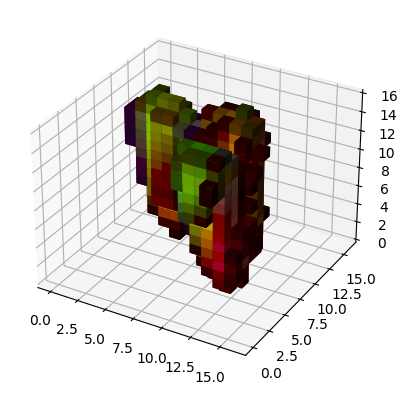

 30%|██▉       | 1500/5001 [17:23<40:25,  1.44it/s]

T_loss: 0.15708152949810028;  f_loss: 0.018722698092460632


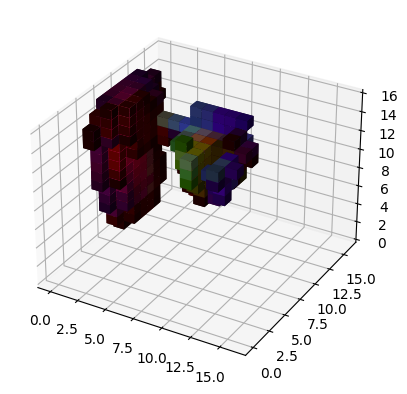

 32%|███▏      | 1600/5001 [18:33<39:15,  1.44it/s]

T_loss: 1.383492112159729;  f_loss: -0.4143025875091553


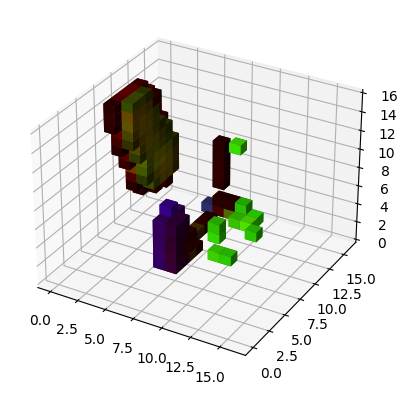

 34%|███▍      | 1700/5001 [19:42<37:37,  1.46it/s]

T_loss: -3.5496087074279785;  f_loss: 0.1765456199645996


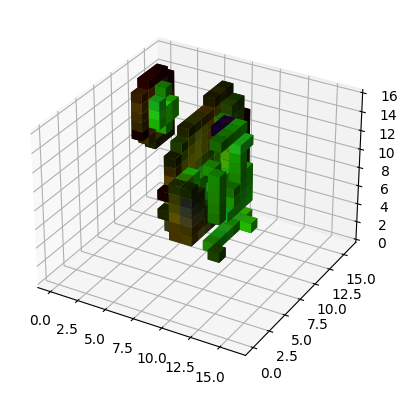

 36%|███▌      | 1800/5001 [20:52<36:48,  1.45it/s]

T_loss: -1.7434555292129517;  f_loss: -0.05434703826904297


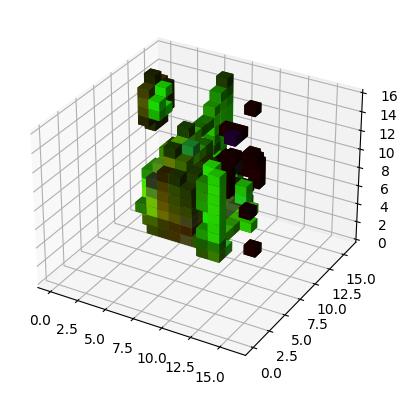

 38%|███▊      | 1900/5001 [22:01<35:47,  1.44it/s]

T_loss: -1.494795322418213;  f_loss: 0.01611173152923584


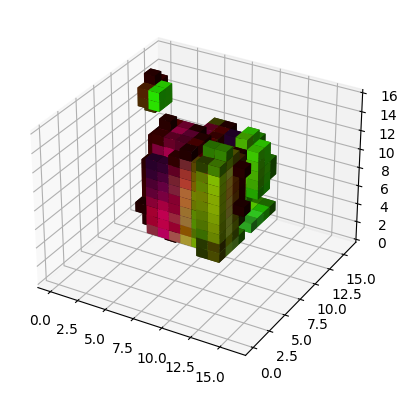

 40%|███▉      | 2000/5001 [23:11<34:37,  1.44it/s]

T_loss: -1.2324556112289429;  f_loss: 0.026282310485839844


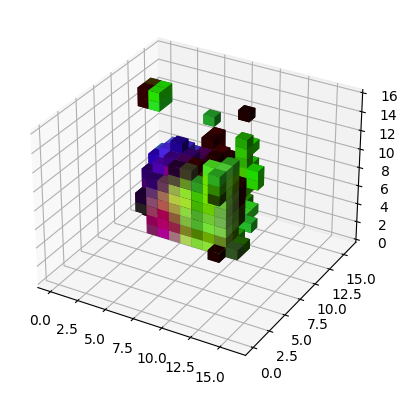

 42%|████▏     | 2100/5001 [24:20<33:26,  1.45it/s]

T_loss: -0.6951292157173157;  f_loss: 0.033640146255493164


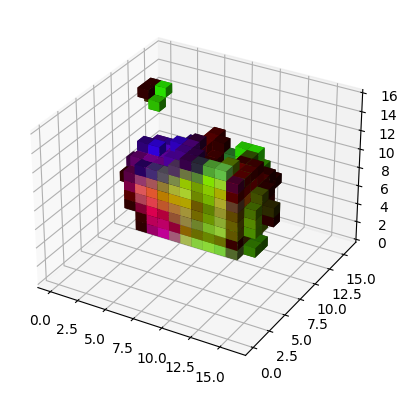

 44%|████▍     | 2200/5001 [25:30<32:07,  1.45it/s]

T_loss: -0.8644033670425415;  f_loss: 0.04057955741882324


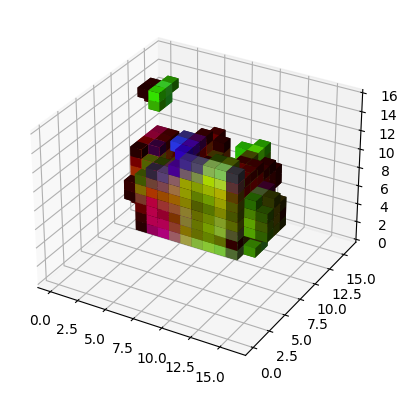

 46%|████▌     | 2300/5001 [26:39<31:11,  1.44it/s]

T_loss: -0.41578710079193115;  f_loss: 0.04194095730781555


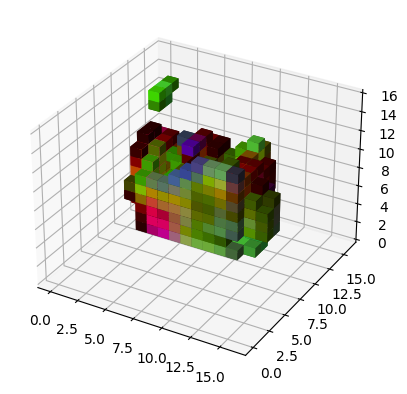

 48%|████▊     | 2400/5001 [27:49<30:00,  1.44it/s]

T_loss: -0.3674333989620209;  f_loss: 0.02285325527191162


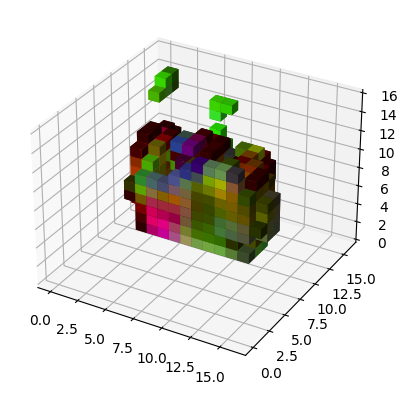

 50%|████▉     | 2500/5001 [28:58<28:50,  1.45it/s]

T_loss: -0.2143409252166748;  f_loss: 0.021918892860412598


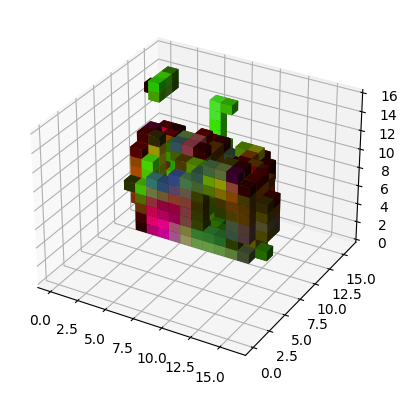

 52%|█████▏    | 2600/5001 [30:08<27:42,  1.44it/s]

T_loss: -0.14611263573169708;  f_loss: 0.016346707940101624


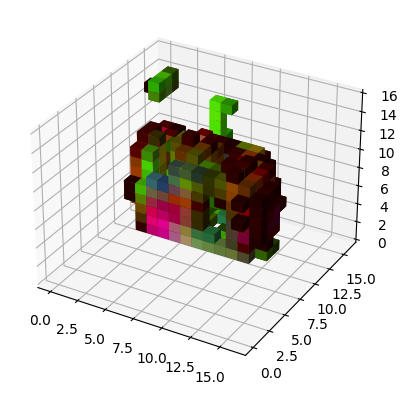

 54%|█████▍    | 2700/5001 [31:18<26:33,  1.44it/s]

T_loss: -0.1836785525083542;  f_loss: 0.0099925696849823


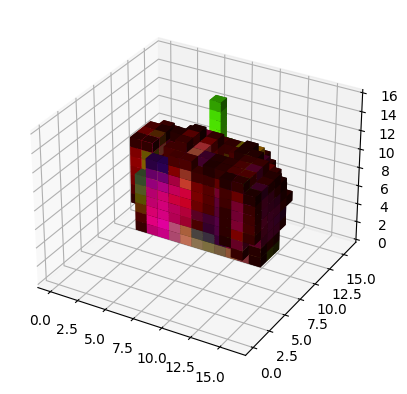

 56%|█████▌    | 2800/5001 [32:27<25:24,  1.44it/s]

T_loss: -0.09372888505458832;  f_loss: 0.009046144783496857


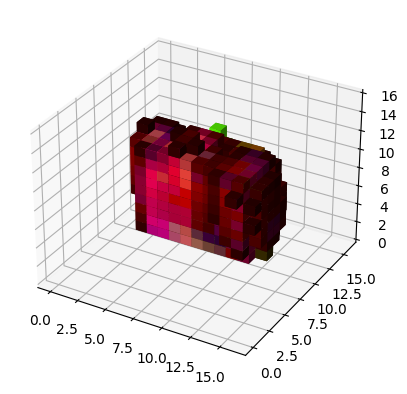

 58%|█████▊    | 2900/5001 [33:37<24:09,  1.45it/s]

T_loss: -0.14341039955615997;  f_loss: 0.01316024363040924


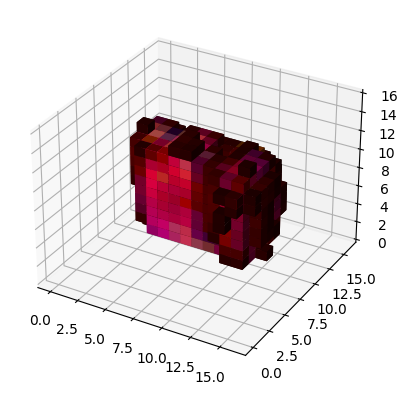

 60%|█████▉    | 3000/5001 [34:46<23:06,  1.44it/s]

T_loss: -0.35134515166282654;  f_loss: 0.016860753297805786


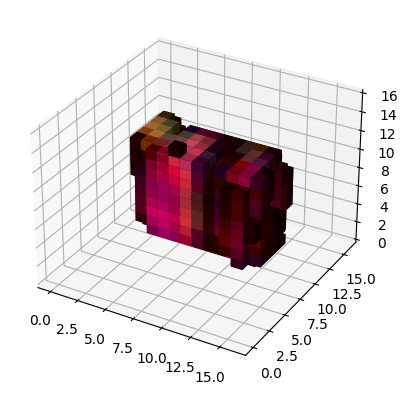

 62%|██████▏   | 3100/5001 [35:56<21:56,  1.44it/s]

T_loss: -0.033402372151613235;  f_loss: 0.007013130933046341


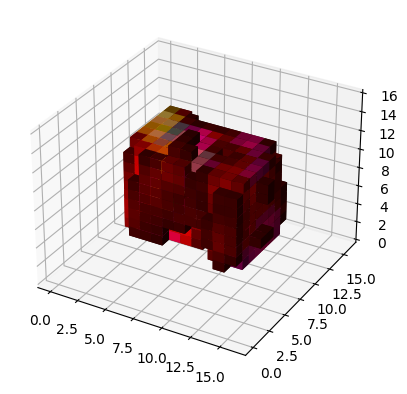

 64%|██████▍   | 3200/5001 [37:06<20:45,  1.45it/s]

T_loss: -0.14702032506465912;  f_loss: 0.005494624376296997


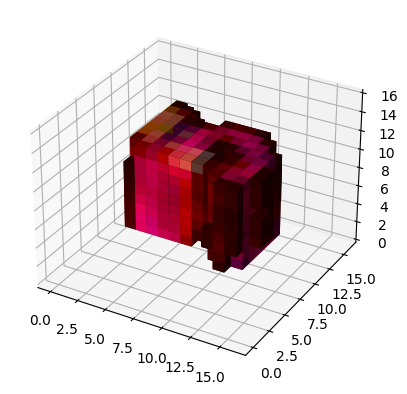

 66%|██████▌   | 3300/5001 [38:15<19:32,  1.45it/s]

T_loss: -0.12657472491264343;  f_loss: 0.00718003511428833


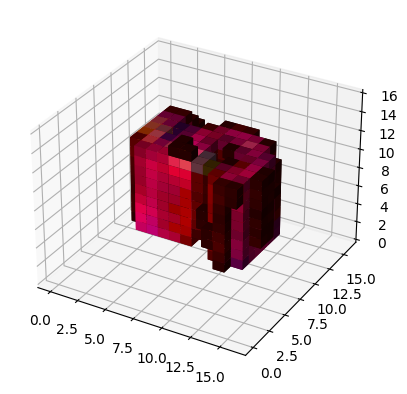

 68%|██████▊   | 3400/5001 [39:25<18:16,  1.46it/s]

T_loss: -0.09276658296585083;  f_loss: 0.0034779980778694153


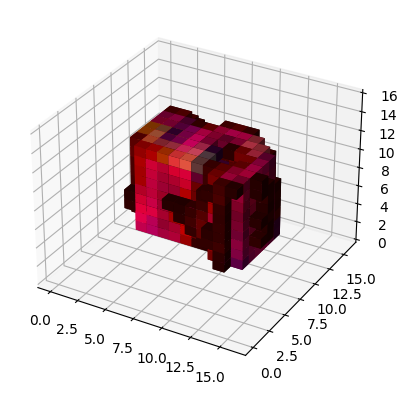

 70%|██████▉   | 3500/5001 [40:35<17:20,  1.44it/s]

T_loss: -0.09173376113176346;  f_loss: 0.004191100597381592


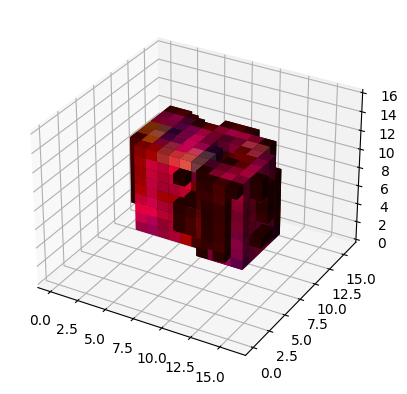

 72%|███████▏  | 3600/5001 [41:44<16:09,  1.45it/s]

T_loss: -0.10702277719974518;  f_loss: 0.0025856047868728638


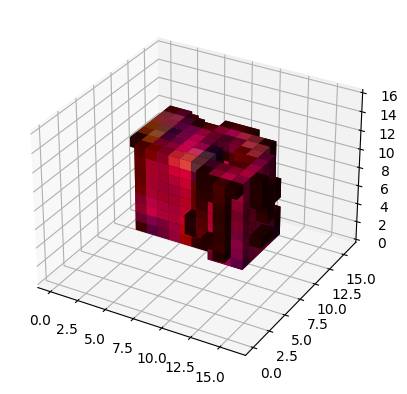

 74%|███████▍  | 3700/5001 [42:54<15:01,  1.44it/s]

T_loss: -0.09819599986076355;  f_loss: 0.0014065206050872803


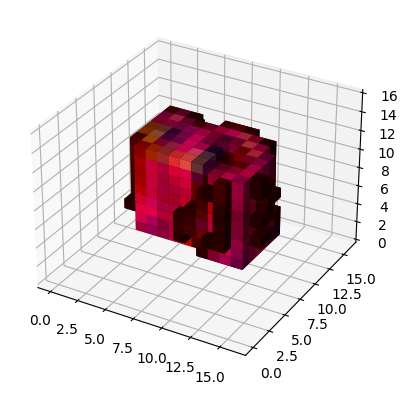

 76%|███████▌  | 3800/5001 [44:04<13:51,  1.44it/s]

T_loss: -0.11416254937648773;  f_loss: 0.0043369680643081665


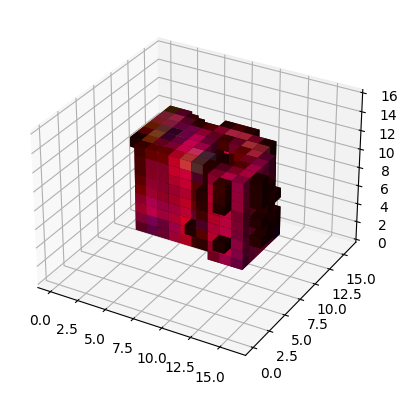

 78%|███████▊  | 3900/5001 [45:13<12:42,  1.44it/s]

T_loss: -0.1073300689458847;  f_loss: 0.002638399600982666


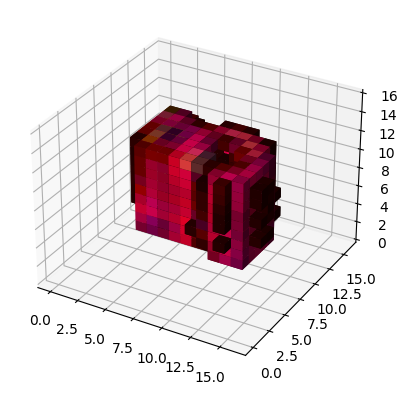

 80%|███████▉  | 4000/5001 [46:23<11:30,  1.45it/s]

T_loss: -0.13041026890277863;  f_loss: 0.0029598623514175415


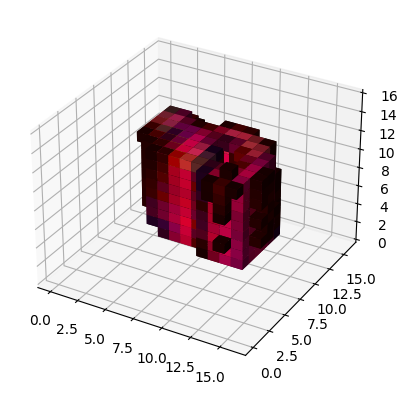

 82%|████████▏ | 4100/5001 [47:32<10:24,  1.44it/s]

T_loss: -0.0791366696357727;  f_loss: 0.000688605010509491


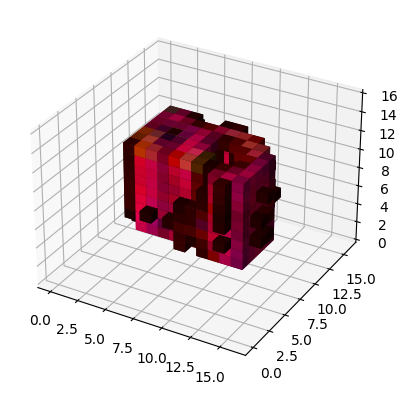

 84%|████████▍ | 4200/5001 [48:42<09:15,  1.44it/s]

T_loss: -0.10499876737594604;  f_loss: 0.0006576031446456909


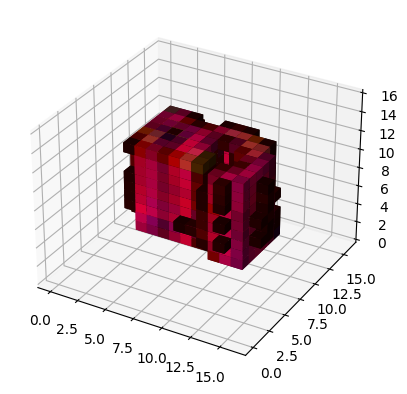

 86%|████████▌ | 4300/5001 [49:52<08:05,  1.44it/s]

T_loss: -0.10446292161941528;  f_loss: 0.0021617934107780457


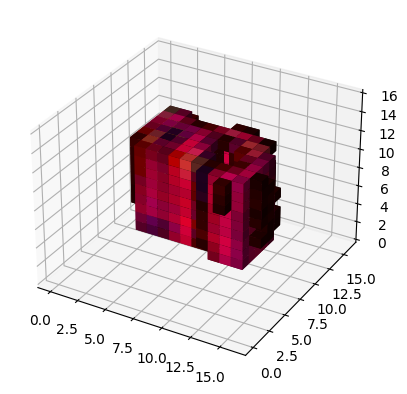

 88%|████████▊ | 4400/5001 [51:02<06:54,  1.45it/s]

T_loss: -0.0031497455202043056;  f_loss: 0.004789747763425112


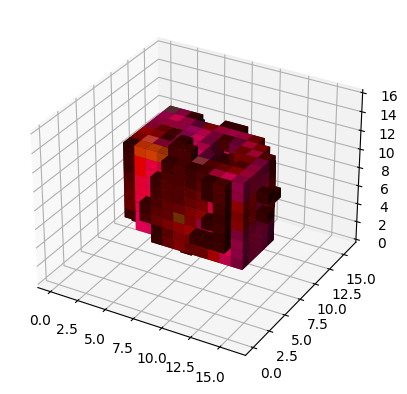

 90%|████████▉ | 4500/5001 [52:11<05:47,  1.44it/s]

T_loss: -0.03751207888126373;  f_loss: 1.5813857316970825e-05


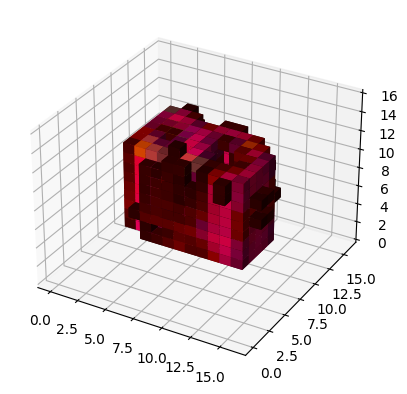

 92%|█████████▏| 4600/5001 [53:21<04:37,  1.44it/s]

T_loss: -0.05594705045223236;  f_loss: 0.00027007609605789185


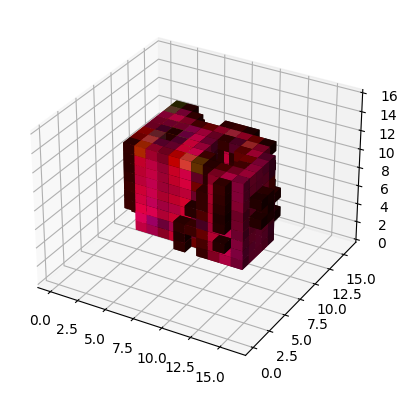

 94%|█████████▍| 4700/5001 [54:30<03:27,  1.45it/s]

T_loss: -0.0418914295732975;  f_loss: 0.0013837777078151703


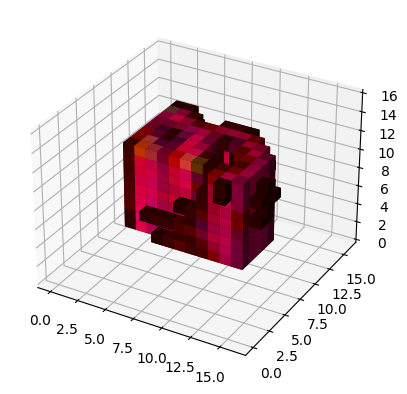

 96%|█████████▌| 4800/5001 [55:40<02:18,  1.45it/s]

T_loss: -0.03660162538290024;  f_loss: 0.0003101080656051636


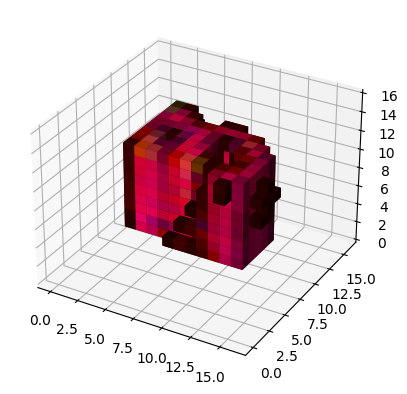

 98%|█████████▊| 4900/5001 [56:50<01:09,  1.44it/s]

T_loss: -0.09541425853967667;  f_loss: 0.0021805912256240845


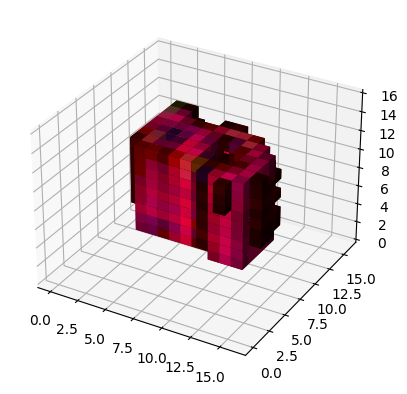

100%|█████████▉| 5000/5001 [57:59<00:00,  1.44it/s]

T_loss: -0.10463152080774307;  f_loss: 0.004263333976268768


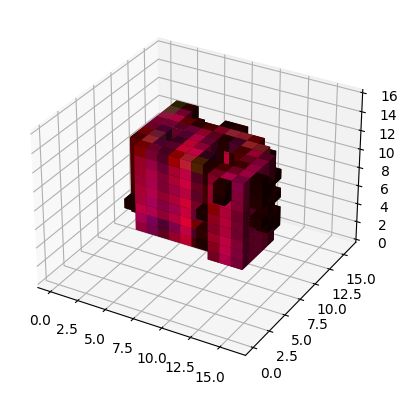

100%|██████████| 5001/5001 [58:01<00:00,  1.44it/s]


In [11]:
test_batch = sample_test()
plot_img(test_batch[0])

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()


    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        torch.save(T.state_dict, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [46]:
test_batch = sample_test().cuda()

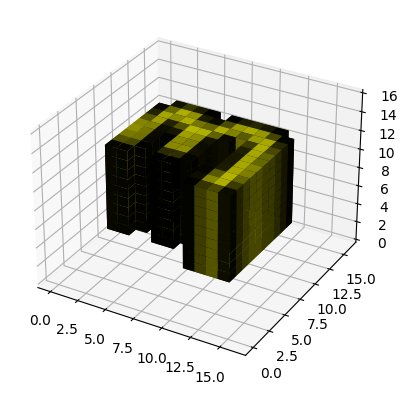

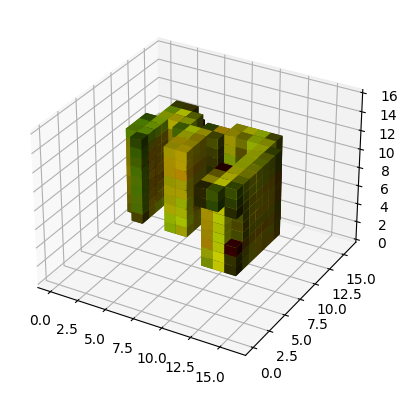

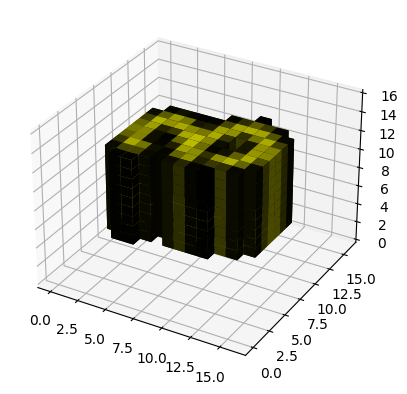

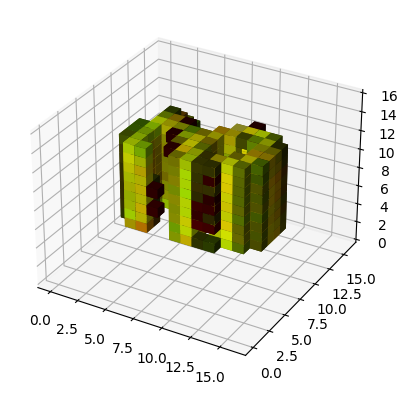

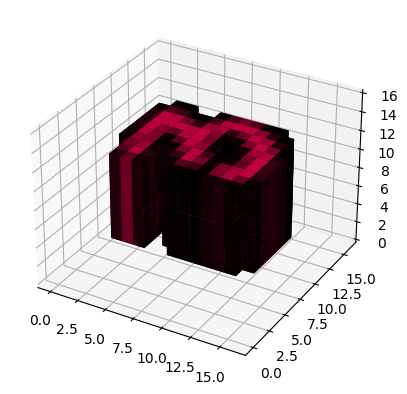

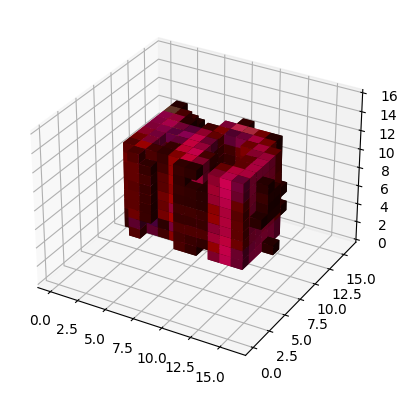

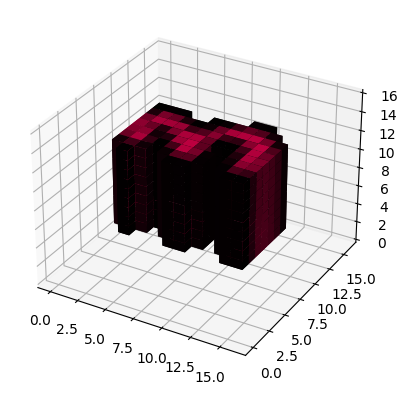

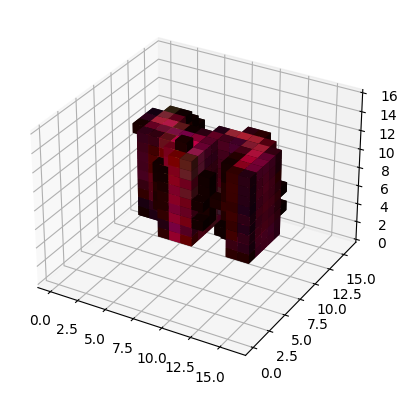

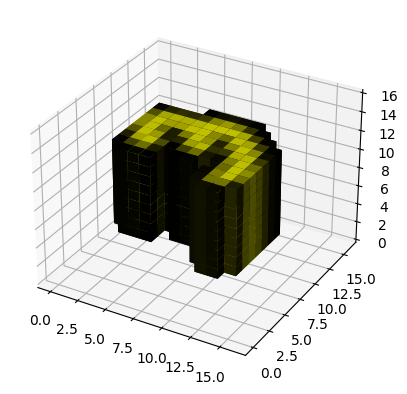

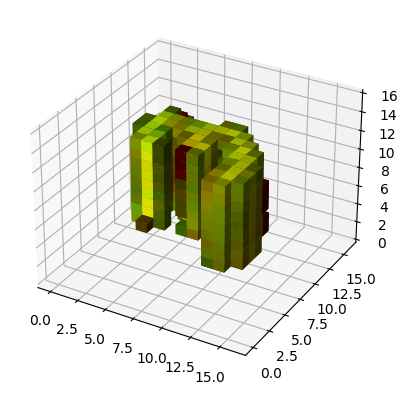

In [47]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)

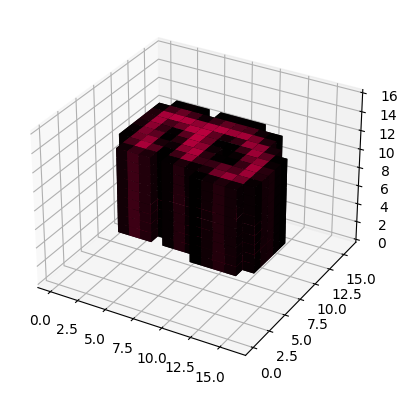

In [13]:
plot_img(test_batch[0])

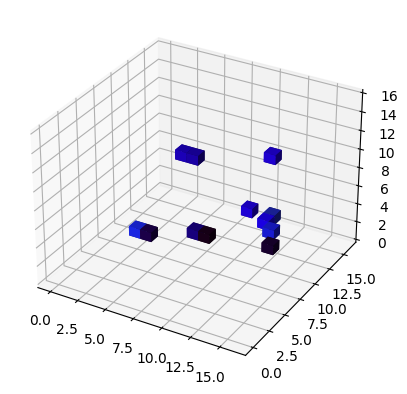

In [14]:
T_X = torch.clip(T(X)[0].cpu().detach(), min=0, max=1)
T_X[T_X < 0.1] = 0

plot_img(T_X)

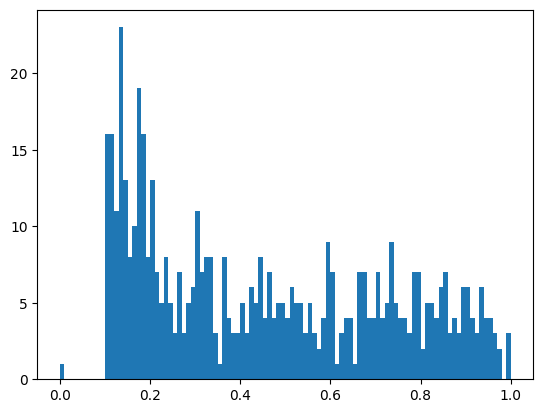

In [15]:
plt.hist(T_X.unique(), bins=100)
plt.show()

In [16]:
T_1000 = UNet(3, 3).cuda()
checkpoint = torch.load("weights/OT_1000.pt")
T_1000.load_state_dict(checkpoint())

T_1000.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): Ba

In [17]:
test_batch = next(iter(mnist_test))

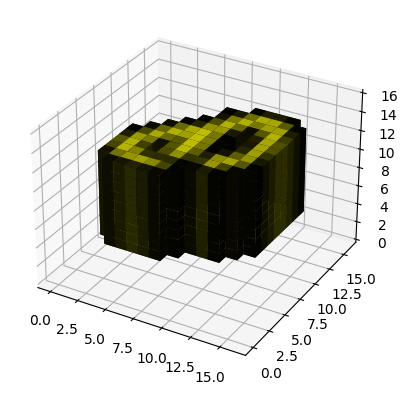

In [18]:
plot_img(test_batch[0])